In [1]:
import pickle, os
from itertools import islice
import numpy as np, scipy as sp, pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 40)
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcdefaults()
if hasattr(__builtins__, '__IPYTHON__'):
    get_ipython().run_line_magic('matplotlib', 'inline')
    get_ipython().run_line_magic('config', 'InlineBackend.figure_format = "jpg"')
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
    # https://stackoverflow.com/questions/70766518/how-to-change-ipython-error-highlighting-color
    from IPython.core import ultratb
    print(ultratb.VerboseTB._tb_highlight)
    ultratb.VerboseTB._tb_highlight = "bg:#006400"

bg:ansiyellow


In [2]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='simhei.ttf')

In [3]:
%run util.ipynb

bg:#006400


In [4]:
from math import radians, sin, cos, ceil, floor
import time

In [5]:
e_mat = np.load('data_taiwan/dem.npy')
df_peak = pd.read_pickle('data_taiwan/df_peak.pkl')
yx_2_peakidx = np.load('data_taiwan/yx_2_peakidx.npy')
e_mat.shape, yx_2_peakidx.shape, e_mat.dtype, yx_2_peakidx.dtype

((2886, 5640), (2886, 5640), dtype('float64'), dtype('int64'))

In [6]:
x20, y20 = latlon_2_twd97(24.9748287, 121.6303675)
# x20, y20 = latlon_2_twd97(24.96781060702343, 121.72734731291241)
viewer_x, viewer_y = x20_2_x(x20), y20_2_y(y20)
n = 1
viewer_z = e_mat[
    np.maximum(0, floor(viewer_y) - n): np.minimum(e_mat.shape[0], floor(viewer_y) + n + 2),
    np.maximum(0, floor(viewer_x) - n): np.minimum(e_mat.shape[1], floor(viewer_x) + n + 2),
].max() + 10.
print(viewer_z)
viewer_azimuth, viewer_azimuth_w = 60., 360.
# viewer_azimuth, viewer_azimuth_w = 90., 360.
viewer_eleangle, viewer_eleangle_h = -2., 12.
# viewer_eleangle, viewer_eleangle_h = 0., 16.
img_w, img_h = int(36 * viewer_azimuth_w), int(36 * viewer_eleangle_h)
print(img_w, img_h)

589.71
12960 432


In [7]:
def trace_rays(
    e_mat, i_mat, tip_yf_mat, tip_xf_mat, z_mat, 
    img_h, img_w, i_ub, 
    viewer_x, viewer_y, viewer_z,
    viewer_azimuth, viewer_azimuth_w, 
    viewer_eleangle, viewer_eleangle_h,
):
    for idx_h, az in enumerate(np.linspace(
        viewer_azimuth - viewer_azimuth_w / 2., 
        viewer_azimuth + viewer_azimuth_w / 2., 
        img_w,
        dtype=np.float64,
    )): 
        if idx_h % 100 == 0:
            print(idx_h, end=' ', flush=True)
        dire_x, dire_y = cos(radians(90. - az)), sin(radians(90. - az))
        i = 0
        for idx_v, eleang in enumerate(np.linspace(
            viewer_eleangle - viewer_eleangle_h / 2., 
            viewer_eleangle + viewer_eleangle_h / 2., 
            img_h,
            dtype=np.float64,
        )): 
            while i < i_ub:
                dire_z = sin(radians(eleang))
                dist = i * 1.
                tip_x, tip_y, tip_z = (
                    viewer_x + dire_x * dist, 
                    viewer_y + dire_y * dist, 
                    viewer_z + dire_z * dist * 20.,
                )
                tip_xf, tip_xc, tip_yf, tip_yc = floor(tip_x), ceil(tip_x), floor(tip_y), ceil(tip_y)
                if (tip_yf < 0) or (tip_yc >= e_mat.shape[0]) or (tip_xf < 0) or (tip_xc >= e_mat.shape[1]):
                    i = i_ub
                    break
                z = (e_mat[tip_yf, tip_xf] * (tip_xc - tip_x) + e_mat[tip_yf, tip_xc] * (tip_x - tip_xf)) * (tip_yc - tip_y) + \
                    (e_mat[tip_yc, tip_xf] * (tip_xc - tip_x) + e_mat[tip_yc, tip_xc] * (tip_x - tip_xf)) * (tip_y - tip_yf)
                if z >= tip_z:
                    i_mat     [idx_v, idx_h] = i
                    tip_yf_mat[idx_v, idx_h] = tip_yf
                    tip_xf_mat[idx_v, idx_h] = tip_xf
                    z_mat     [idx_v, idx_h] = z
                    break
                i += 1
    print()

In [8]:
i_ub = 3000
i_mat = np.full((img_h, img_w), i_ub, dtype=np.int64, order='C')
tip_yf_mat = np.full((img_h, img_w), -1, dtype=np.int64, order='C')
tip_xf_mat = np.full((img_h, img_w), -1, dtype=np.int64, order='C')
z_mat = np.full((img_h, img_w), np.NINF, dtype=np.float64, order='C')
# i_mat = np.full((img_h, img_w), -1., dtype=np.float64, order='F')

In [9]:
# t = time.time()
# trace_rays(
#     e_mat, i_mat, tip_yf_mat, tip_xf_mat, z_mat, 
#     img_h, img_w, i_ub, 
#     viewer_x, viewer_y, viewer_z,
#     viewer_azimuth, viewer_azimuth_w, 
#     viewer_eleangle, viewer_eleangle_h,
# )
# print(time.time() - t)

In [10]:
import ray_tracing_cpp # todo: Why doesn't autoreload work ?
t = time.time()
ray_tracing_cpp.trace_rays(
    e_mat, i_mat, tip_yf_mat, tip_xf_mat, z_mat, 
    img_h, img_w, i_ub, 
    viewer_x, viewer_y, viewer_z,
    viewer_azimuth, viewer_azimuth_w, 
    viewer_eleangle, viewer_eleangle_h,
)
print(time.time() - t)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 
0.4584190845489502


In [11]:
idxs0 = (i_mat < i_ub).nonzero()
idxs1 = (yx_2_peakidx[tip_yf_mat[idxs0], tip_xf_mat[idxs0]] >= 0).nonzero()
idxs2 = (idxs0[0][idxs1], idxs0[1][idxs1])
df_peak_in_sight = pd.DataFrame({
    'idx_v': idxs2[0],
    'idx_h': idxs2[1],
    'z': z_mat[idxs2],
    'i': i_mat[idxs2],
    'peakidx': yx_2_peakidx[tip_yf_mat[idxs2], tip_xf_mat[idxs2]],
})
print(df_peak_in_sight.shape)
df_peak_in_sight.dtypes

(517601, 5)


idx_v        int64
idx_h        int64
z          float64
i            int64
peakidx      int64
dtype: object

In [12]:
df_peak_pos = df_peak_in_sight.iloc[df_peak_in_sight.groupby('peakidx')['z'].idxmax()].reset_index(drop=True) # Problematic when viewer_azimuth_w > 360

In [13]:
df_peak_pos

,idx_v,idx_h,z,i,peakidx
0,236,504,478.249695,225,1
1,272,6743,551.572989,280,2
2,285,6776,588.889524,313,3
3,292,3426,641.397186,1057,4
4,314,3714,885.614811,1136,5
...,...,...,...,...,...
445,154,2770,215.978534,297,1061
446,256,1119,228.061591,1194,1065
447,292,3636,641.097618,1061,1066
448,245,3284,197.691187,958,1069


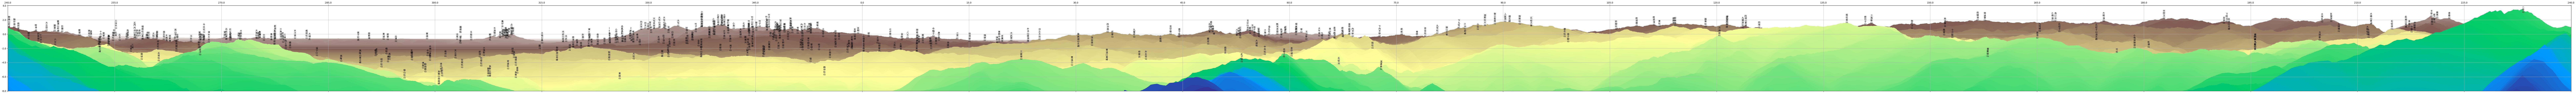

In [14]:
fig, ax = plt.subplots(figsize=(viewer_azimuth_w / 1.8,) * 2)
ax.matshow(np.log(i_mat), origin='lower', cmap='terrain');

mx, my = int(viewer_azimuth_w / 15.) + 1, int(viewer_eleangle_h / 2.) + 1
ax.set_xticks(np.linspace(0., img_w - 1., mx, dtype=np.float64))
ax.set_xticklabels((np.linspace(
    viewer_azimuth - viewer_azimuth_w / 2., 
    viewer_azimuth + viewer_azimuth_w / 2., 
    mx, 
    dtype=np.float64,
) % 360).astype(str))
ax.set_yticks(np.linspace(0., img_h - 1., my, dtype=np.float64))
ax.set_yticklabels(np.linspace(
    viewer_eleangle - viewer_eleangle_h / 2., 
    viewer_eleangle + viewer_eleangle_h / 2., 
    my, 
    dtype=np.float64,
).astype(str))
ax.grid();

for row in df_peak_pos.itertuples(index=False, name='row'):
    ax.text(row.idx_h, row.idx_v, '\n'.join(df_peak.at[row.peakidx, 'name'][:7]), fontproperties=font);

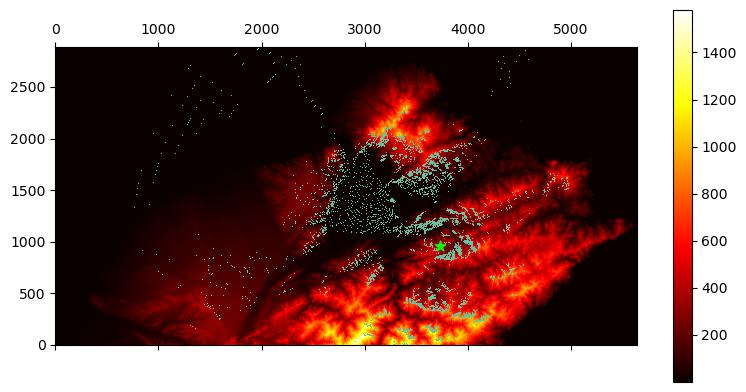

In [15]:
from numpy import ma
plt.matshow(e_mat, origin='lower', cmap='hot');
plt.gca().set_aspect('equal');
plt.colorbar();
reach = np.zeros_like(e_mat, dtype=bool)
reach[tip_yf_mat[i_mat < i_ub], tip_xf_mat[i_mat < i_ub]] = True
plt.gca().matshow(ma.masked_values(reach, False), origin='lower', cmap='Set2');
plt.scatter(viewer_x, viewer_y, c='lime', s=60, marker='*');